In [13]:
import sys
import os

# Navigate up one level to the parent directory and append it to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import nfl_data_py as nfl
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import poisson

from src import utils

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

import jupyter_black

jupyter_black.load()

warnings.simplefilter(action='ignore', category=FutureWarning) # Ignore all future warnings
pd.set_option('display.max_columns', None)

In [14]:
flatten_grouped_cols = lambda cols: list(map("_".join, cols))


def lag_df(
    df: pd.DataFrame, index_cols: list, cols_to_lag: list, lag_on="season"
) -> pd.DataFrame:
    df_cur = df[index_cols + cols_to_lag].copy()
    df_prev = df_cur.copy()
    df_prev = df_prev.rename(columns={col: f"{col}_last" for col in cols_to_lag})
    df_prev[lag_on] += 1
    return df_cur.merge(df_prev, how="inner", on=index_cols)

# 1. Football Analytics

The goal of this chapter is to get familiar with nfl_data_py and analyze QB ADOT

In [ ]:
pbp = nfl.import_pbp_data([2023])

In [ ]:
filter_criteria = 'play_type=="pass" & air_yards.notnull()'

pass_pbp = (
    pbp.query(filter_criteria)
    # .groupby(['passer_id', 'passer'])
    .groupby(['passer', 'posteam'])
    .agg({'air_yards': ['count', 'mean'], 'epa':'mean'})
)

pass_pbp.columns = list(map('_'.join, pass_pbp.columns.values))
pass_pbp = pass_pbp[pass_pbp['air_yards_count'] >= 100].sort_values('air_yards_mean', ascending=False).reset_index()
pass_pbp

In [ ]:
fig = px.scatter(pass_pbp, x='air_yards_mean', y='epa_mean', text='passer', color='posteam', color_discrete_map=utils.team_primary_colors, opacity=0)
fig.update_layout(
    height=600,
    width=1000,
    xaxis_title=f'Mean ADOT',
    yaxis_title='EPA per Play',
    title='QB EPA per Play by Mean ADOT',
    # subheader='min 100 pass attempts',
)
fig.update_traces(showlegend=False, textposition='bottom center')

# Iterate through the data and add logos to the chart
for index, row in pass_pbp.iterrows():
    team = row['posteam']
    scale = .16
    fig.add_layout_image(
        dict(source=f'https://a.espncdn.com/i/teamlogos/nfl/500/{team}.png',
            x=row['air_yards_mean'],
            y=row['epa_mean'],
            xref="x",
            yref="y",
            sizex=scale,  # Adjust the size
            sizey=scale,  # Adjust the size
            sizing="contain",
            opacity=.6,
            xanchor="center",
            yanchor="middle",        
            layer="below",
        )
    )

fig.show()

# 2. Stable vs Unstable QB Metrics

## Pass Data Prep

In [ ]:
pbp = pd.DataFrame(nfl.import_pbp_data(range(2016, 2023)))
pbp.shape

In [ ]:
# filter to only passing data
pbp_p = pbp.query("play_type == 'pass' & air_yards.notnull()").reset_index()

In [ ]:
# categorize passes as either long or short
pbp_p['pass_length_air_yards'] = np.where(pbp_p['air_yards'] >= 20, 'long', 'short')
# fill in pass yards as 0's if they are indeed null
pbp_p['passing_yards'] = pbp_p['passing_yards'].fillna(0)

In [ ]:
pbp_p['passing_yards'].describe()

In [ ]:
pbp_p.query('pass_length_air_yards == "long"')['passing_yards'].describe()

In [ ]:
pbp_p.query('pass_length_air_yards == "short"')['passing_yards'].describe()

In [ ]:
pbp_p.query('pass_length_air_yards == "long"')['epa'].describe()

In [ ]:
pbp_p.query('pass_length_air_yards == "short"')['epa'].describe()

In [ ]:
px.histogram(pbp, x='passing_yards', height=500, width=800)

In [ ]:
px.box(pbp_p, 
        x='pass_length_air_yards', 
        y='passing_yards',
        height=600, 
        width=500
    )

In [ ]:
pbp_p_s = pbp_p.groupby(['passer_id', 'passer', 'season']).agg({'passing_yards': ['mean', 'count']})
pbp_p_s.columns = list(map('_'.join, pbp_p_s.columns))
pbp_p_s = pbp_p_s.rename(columns={
    'passing_yards_mean': 'ypa',
    'passing_yards_count': 'n',
})
pbp_p_s = pbp_p_s.query('n >= 100').sort_values(by='ypa', ascending=False)
pbp_p_s.head()

## The Hypothesis

*Throwing Deep Passes is more valuable than short passes, but it is difficult to say whether or not a quarterback is good at deep passes*

In [ ]:
# play-by-play, pass data, by season, by pass length
pbp_p_s_pl = pbp_p.groupby(['passer_id', 'passer', 'season', 'pass_length_air_yards']).agg({'passing_yards': ['mean', 'count']})
pbp_p_s_pl.columns = list(map('_'.join, pbp_p_s_pl.columns))
pbp_p_s_pl = pbp_p_s_pl.rename(columns={
    'passing_yards_mean': 'ypa',
    'passing_yards_count': 'n',
})
pbp_p_s_pl = pbp_p_s_pl.reset_index()
criteria = '(n >= 100 & pass_length_air_yards=="short") | (n >= 30 & pass_length_air_yards=="long")'
pbp_p_s_pl = pbp_p_s_pl.query(criteria).reset_index()

In [ ]:
air_yards = pbp_p_s_pl[['passer_id', 'passer', 'season', 'pass_length_air_yards', 'ypa']].copy()

In [ ]:
# get the lag from the prior season
air_yards_lag = air_yards.copy().rename(columns={'ypa': 'ypa_last'})
air_yards_lag['season'] += 1

In [ ]:
# join back to the main df
pbp_p_s_pl = (
    air_yards.merge(air_yards_lag, 
                    how="inner",
                    on=["passer_id", "passer", "season", "pass_length_air_yards"]
                )
)

In [ ]:
pbp_p_s_pl.query('passer=="P.Mahomes" or passer == "B.Mayfield"').sort_values(['passer', 'season'])

In [ ]:
assert not pbp_p_s_pl.isnull().any().any()
print(f'{pbp_p_s_pl["passer_id"].nunique()} quarterbacks in the sample')

In [ ]:
# scatterplot for yard per attempt season and previous season
sns.lmplot(
    data=pbp_p_s_pl,
    x='ypa',
    y='ypa_last',
    col='pass_length_air_yards'
)

In [ ]:
pbp_p_s_pl.groupby('pass_length_air_yards')[['ypa', 'ypa_last']].corr()

We can now confirm that throwing deep passes is more valuable than throwing short passes, however it is difficult to say whether or not a quarterback is good at throwing deep passes.

In [ ]:
# Trying the same approach but for epa

In [ ]:
# play-by-play, pass data, by season, by pass length
pbp_p_s_pl = pbp_p.groupby(['passer_id', 'passer', 'season', 'pass_length_air_yards']).agg({'epa': ['mean', 'count']})
pbp_p_s_pl.columns = list(map('_'.join, pbp_p_s_pl.columns))
pbp_p_s_pl = pbp_p_s_pl.rename(columns={
    'epa_mean': 'epa_p',
    'epa_count': 'n',
})
pbp_p_s_pl = pbp_p_s_pl.reset_index()
criteria = '(n >= 100 & pass_length_air_yards=="short") | (n >= 30 & pass_length_air_yards=="long")'
pbp_p_s_pl = pbp_p_s_pl.query(criteria).reset_index()

In [ ]:
air_yards = pbp_p_s_pl[['passer_id', 'passer', 'season', 'pass_length_air_yards', 'epa_p']].copy()

In [ ]:
# get the lag from the prior season
air_yards_lag = air_yards.copy().rename(columns={'epa_p': 'epa_p_last'})
air_yards_lag['season'] += 1

In [ ]:
# join back to the main df
pbp_p_s_pl = (
    air_yards.merge(air_yards_lag, 
                    how="inner",
                    on=["passer_id", "passer", "season", "pass_length_air_yards"]
                )
)

In [ ]:
pbp_p_s_pl.query('passer=="P.Mahomes" or passer == "B.Mayfield"').sort_values(['passer', 'season'])

In [ ]:
assert not pbp_p_s_pl.isnull().any().any()
print(f'{pbp_p_s_pl["passer_id"].nunique()} quarterbacks in the sample')

In [ ]:
# scatterplot for yard per attempt season and previous season
sns.lmplot(
    data=pbp_p_s_pl,
    x='epa_p',
    y='epa_p_last',
    col='pass_length_air_yards'
)

In [ ]:
pbp_p_s_pl.groupby('pass_length_air_yards')[['epa_p', 'epa_p_last']].corr()

Epa is not that different than yards per play when trying to evaluate quarterback play. It is more valuable to throw deep passes but less likely to translate year to year.

# 3. Simple Linear Regression: Rushing Yards over Expected

## Data Wrangling and EDA

In [ ]:
pbp = pd.DataFrame(nfl.import_pbp_data(range(2016, 2022 + 1)))

In [ ]:
criteria = "play_type == 'run' & rusher_id.notnull()"
pbp_run = pbp.query(criteria).reset_index()
pbp_run['rushing_yards'] = pbp_run['rushing_yards'].fillna(0)
pbp_run.head()

In [ ]:
sns.scatterplot(pbp_run, x='ydstogo', y='rushing_yards')

In [ ]:
sns.regplot(pbp_run, x='ydstogo', y='rushing_yards')

In [ ]:
pbp_run_avg = pbp_run.groupby('ydstogo').agg({'rushing_yards': ['mean']})
pbp_run_avg.columns = list(map('_'.join, pbp_run_avg.columns))
pbp_run_avg = pbp_run_avg.reset_index()

In [ ]:
sns.regplot(pbp_run_avg, x='ydstogo', y='rushing_yards_mean')

## Rush Yards Over Expectation 

In [ ]:
yards_to_go = smf.ols('rushing_yards ~ 1 + ydstogo', pbp_run)
yards_to_go.fit().summary()

In [ ]:
# save the residuals 
pbp_run['ryoe'] = yards_to_go.fit().resid

In [ ]:
ryoe = pbp_run.groupby(['season', 'rusher_id', 'rusher']).agg({'ryoe': ['count', 'sum', 'mean'], 'rushing_yards':['mean']})
ryoe.columns = flatten_grouped_cols(ryoe)
ryoe = (
    ryoe.reset_index()
    .rename(columns={
        'ryoe_count': 'n',
        'ryoe_sum': 'ryoe_total',
        'ryoe_mean': 'ryoe_per',
        'rushing_yards_mean': 'yards_per_carry',
    })
    .query('n>=50')
    .sort_values('ryoe_total', ascending=False)
)

In [ ]:
ryoe.head(20)

In [ ]:
ryoe.sort_values('ryoe_per', ascending=False).head(20)

## Cool, now is RYOE a more predictive metric than YPC?

In [ ]:
# lag the df
ryoe_lag = lag_df(ryoe, index_cols=['season', 'rusher_id', 'rusher'], cols_to_lag=['ryoe_per', 'yards_per_carry'], lag_on='season')

In [ ]:
ryoe_lag

In [ ]:
ryoe_lag[['yards_per_carry', 'yards_per_carry_last']].corr()

In [ ]:
ryoe_lag[['ryoe_per', 'ryoe_per_last']].corr()

In conclusion, yes RYOE is a *slightly* more stable metric of a running back's performance than yards per carry from season to season

# 4. Multiple Regression: Rushing Yards over Expected

### Data Prep

In [ ]:
pbp = pd.DataFrame(nfl.import_pbp_data(range(2016, 2022 + 1)))

In [ ]:
criteria = "play_type == 'run' & rusher_id.notnull() & down.notnull() & run_location.notnull()"
pbp_run = pbp.query(criteria).reset_index()
pbp_run['rushing_yards'] = pbp_run['rushing_yards'].fillna(0)
# convert downs to strings so they are interpreted as discrete and not continuous
pbp_run["down"] = pbp_run["down"].astype(str) 
pbp_run.head()

### Variable: Down

In [ ]:
g = sns.FacetGrid(
    data=pbp_run,
    col="down"
)

g.map_dataframe(sns.histplot, x="rushing_yards")

In [ ]:
sns.boxplot(data=pbp_run.query('ydstogo == 10'), x='down', y='rushing_yards')

### Variable: Yards to Go

In [ ]:
sns.regplot(
    data=pbp_run,
    x='yardline_100',
    y='rushing_yards',
    scatter_kws={'alpha':0.25},
    line_kws={'color':'red'},
)

In [ ]:
# bin the data by yards to go
pbp_run_y100 = (
    pbp_run.groupby('yardline_100')
    .agg({'rushing_yards':['mean']})
)
pbp_run_y100.columns = flatten_grouped_cols(pbp_run_y100.columns)
pbp_run_y100 = pbp_run_y100.reset_index()

In [ ]:
sns.regplot(
    data=pbp_run_y100,
    x='yardline_100',
    y='rushing_yards_mean',
    scatter_kws={'alpha':0.25},
    line_kws={'color':'red'},
)

### Variable: Run Location

In [ ]:
sns.boxplot(
    data=pbp_run,
    x='run_location',
    y='rushing_yards',
)

### Variable: Score Differential

In [ ]:
sns.regplot(
    data=pbp_run,
    x='score_differential',
    y='rushing_yards',
    scatter_kws={'alpha':0.25},
    line_kws={'color':'red'},
)

In [ ]:
# bin the data by yards to go
pbp_run_sd = (
    pbp_run.groupby('score_differential')
    .agg({'rushing_yards':['mean']})
)
pbp_run_sd.columns = flatten_grouped_cols(pbp_run_sd.columns)
pbp_run_sd = pbp_run_sd.reset_index()

In [ ]:
sns.regplot(
    data=pbp_run_sd,
    x='score_differential',
    y='rushing_yards_mean',
    scatter_kws={'alpha':0.25},
    line_kws={'color':'red'},
)

### Takeaways

These variables all showed a relationship with rushing yards:
* down
* yards to go
* run location
* score differential

## Generalised Linear Modelling: RYOE

In [ ]:
expected_yards = smf.ols(
    data=pbp_run,
    formula='rushing_yards ~ 1 + down + ydstogo + down:ydstogo + yardline_100 + run_location + score_differential'
).fit()
expected_yards.summary()

In [ ]:
pbp_run['ryoe'] = expected_yards.resid

In [ ]:
ryoe = pbp_run.groupby(['season', 'rusher_id', 'rusher']).agg({'ryoe': ['count', 'sum', 'mean'], 'rushing_yards':['mean']})
ryoe.columns = flatten_grouped_cols(ryoe)
ryoe = (
    ryoe.reset_index()
    .rename(columns={
        'ryoe_count': 'n',
        'ryoe_sum': 'ryoe_total',
        'ryoe_mean': 'ryoe_per',
        'rushing_yards_mean': 'yards_per_carry',
    })
    .query('n>=50')
    .sort_values('ryoe_total', ascending=False)
)

In [ ]:
ryoe.head(20)

In [ ]:
ryoe.sort_values('ryoe_per', ascending=False).head(20)

## Is the generalised RYOE model more stable than the simple model?

In [ ]:
# lag the df
ryoe_lag = lag_df(ryoe, index_cols=['season', 'rusher_id', 'rusher'], cols_to_lag=['ryoe_per'], lag_on='season')

In [ ]:
ryoe_lag

In [ ]:
ryoe_lag[['ryoe_per', 'ryoe_per_last']].corr()

Yes! we have improved the correlation from 0.34 to 0.37, a small but positive increase!

# 5. Generalized Linear Models: Completion Percentage over Expected

## Data Prep

In [ ]:
pbp = pd.DataFrame(nfl.import_pbp_data(range(2016, 2022 + 1)))
criteria = 'play_type=="pass" & passer_id.notnull() & air_yards.notnull()'
pbp_pass = (
    pbp.query(criteria)
    .reset_index()
)

In [ ]:
pass_pct = (
    pbp_pass.query('0 < air_yards <= 20')
    .groupby('air_yards')
    .agg({'complete_pass':['mean']})
)
pass_pct.columns = flatten_grouped_cols(pass_pct.columns)
pass_pct = pass_pct.reset_index().rename(columns={'complete_pass_mean':'comp_pct'})

In [ ]:
sns.regplot(pass_pct, x='air_yards', y='comp_pct', line_kws={'color':'red'})

## Simple GLM Completion Percentage and Air Yards

In [ ]:
complete_ay = (
    smf.glm(formula='complete_pass ~ air_yards', 
            data=pbp_pass,
            family=sm.families.Binomial()
    )
    .fit()
)
complete_ay.summary()

Negative coefficient means that deeper passes are less likely to be completed

In [ ]:
# regular linear regression is bad!
sns.regplot(data=pbp_pass, 
            x='air_yards',
            y='complete_pass',
            logistic=False,
            line_kws={'color':'red'},
            scatter_kws={'alpha':0.05})

In [ ]:
# logistic regression better
sns.regplot(data=pbp_pass, 
            x='air_yards',
            y='complete_pass',
            logistic=True,
            line_kws={'color':'red'},
            scatter_kws={'alpha':0.05})

In [ ]:
pbp_pass['exp_completion'] = complete_ay.predict()
pbp_pass['cpoe'] = pbp_pass['complete_pass'] - pbp_pass['exp_completion']

In [ ]:
cpoe = (
    pbp_pass.groupby(['season', 'passer_id', 'passer'])
    .agg({'cpoe': ['count', 'mean'], 'complete_pass': ['mean']})
)
cpoe.columns = flatten_grouped_cols(cpoe.columns)
cpoe = (
    cpoe.reset_index()
    .rename(columns={
        'cpoe_count': 'n',
        'cpoe_mean': 'cpoe',
        'complete_pass_mean': 'compl'
    })
    .query('n > 100')
)
cpoe.sort_values('cpoe', ascending=False)

## Improving CPOE model

In [ ]:
pbp_pass['down'] = pbp_pass['down'].astype(str)
pbp_pass['qb_hit'] = pbp_pass['qb_hit'].astype(str)

pbp_pass_no_miss = (
    pbp_pass[['season', 'passer_id', 'passer', 'down', 'qb_hit', 'complete_pass', 'ydstogo', 'yardline_100', 'air_yards', 'pass_location']]
    .dropna(axis=0)
)

In [ ]:
complete_more = smf.glm(
    formula="complete_pass ~ down * ydstogo + yardline_100 + air_yards + pass_location + qb_hit",
    data=pbp_pass_no_miss,
    family=sm.families.Binomial(),
).fit()
complete_more.summary()

In [ ]:
pbp_pass_no_miss['exp_completion'] = complete_more.predict()
pbp_pass_no_miss['cpoe'] = pbp_pass_no_miss['complete_pass'] - pbp_pass_no_miss['exp_completion']

In [ ]:
cpoe_more = (
    pbp_pass_no_miss.groupby(['season', 'passer_id', 'passer'])
    .agg({'cpoe': ['count', 'mean'], 'complete_pass': ['mean']})
)
cpoe_more.columns = flatten_grouped_cols(cpoe_more.columns)
cpoe_more = (
    cpoe_more.reset_index()
    .rename(columns={
        'cpoe_count': 'n',
        'cpoe_mean': 'cpoe',
        'complete_pass_mean': 'compl'
    })
    .query('n > 100')
)
cpoe_more.sort_values('cpoe', ascending=False)

## Is CPOE more stable than completion percentage?

In [ ]:
cpoe_lag = lag_df(cpoe_more, index_cols=['season', 'passer_id', 'passer'], cols_to_lag=['cpoe', 'compl'], lag_on='season')

In [ ]:
cpoe_lag[['compl', 'compl_last']].corr()

In [ ]:
cpoe_lag[['cpoe', 'cpoe_last']].corr()

# 6. Data Science for Sports Betting: Poisson Regression and Passing Touchdowns

### Data Prep

In [5]:
pbp = pd.DataFrame(nfl.import_pbp_data(range(2016, 2022 + 1)))
criteria = 'passer_id.notnull()'
pbp_pass = (
    pbp.query(criteria)
    .reset_index()
)

2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
Downcasting floats.


In [6]:
pbp_pass['pass_touchdown'] = pbp_pass['pass_touchdown'].fillna(0)
pbp_pass['passer'] = pbp_pass['passer'].fillna('none')
pbp_pass['passer_id'] = pbp_pass['passer_id'].fillna('none')

In [7]:
pbp_pass_td_y = (
    pbp_pass.groupby(['season', 'week', 'passer_id', 'passer'])
    .agg({'pass_touchdown': ['sum'], 'total_line':['count', 'mean']})
)
pbp_pass_td_y.columns = flatten_grouped_cols(pbp_pass_td_y.columns)
pbp_pass_td_y = (
    pbp_pass_td_y.reset_index()
    .rename(columns={
        'pass_touchdown_sum': 'pass_td_y',
        'total_line_mean': 'total_line',
        'total_line_count': 'n_passes',
    })
    .query('n_passes >= 10')
)

In [8]:
pbp_pass_td_y.groupby('pass_td_y').agg({'n_passes':'count'})

,n_passes
pass_td_y,
0.0,902
1.0,1286
2.0,1050
3.0,506
4.0,186
5.0,31
6.0,4


In [9]:
pbp_pass_td_y.describe()

,season,week,pass_td_y,n_passes,total_line
count,3965.000000,3965.000000,3965.000000,3965.000000,3965.000000
mean,2019.048928,9.620177,1.469609,38.802018,45.770618
std,2.008968,5.391064,1.164081,10.623565,4.409121
min,2016.000000,1.000000,0.000000,10.000000,32.000000
25%,2017.000000,5.000000,1.000000,32.000000,42.500000
50%,2019.000000,10.000000,1.000000,39.000000,45.500000
75%,2021.000000,14.000000,2.000000,46.000000,48.500000
max,2022.000000,22.000000,6.000000,84.000000,63.500000


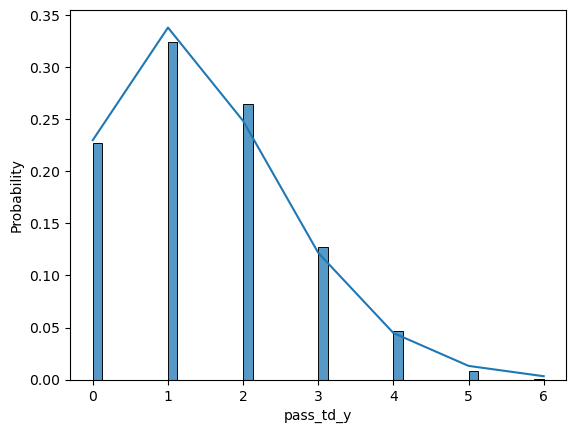

In [12]:
pass_td_y_mean = pbp_pass_td_y['pass_td_y'].mean()

plot_pos = pd.DataFrame({
            'x': range(7),
            'expected':[poisson.pmf(x, pass_td_y_mean) for x in range(7)]
        })

sns.histplot(pbp_pass_td_y['pass_td_y'], stat='probability')
plt.plot(plot_pos.x, plot_pos.expected)
plt.show()

In [19]:
# only look into players with pass attempts >10
pbp_pass_td_y_geq10 = pbp_pass_td_y.query("n_passes >= 10")


# take the avg td passes for each qb for the previous and current seasons
def get_pass_td_rate_previous_and_curent_seasons(season_id, week_id):
    query_str = f"(season=={season_id - 1}) | (season=={season_id} & week < {week_id})"
    weekly_pass_td = (
        pbp_pass_td_y_geq10.query(query_str)
        .groupby(["passer_id", "passer"])
        .agg({"pass_td_y": ["count", "mean"]})
    )
    weekly_pass_td.columns = flatten_grouped_cols(weekly_pass_td.columns)
    weekly_pass_td = weekly_pass_td.reset_index().rename(
        columns={
            "pass_td_y_count": "n_games",
            "pass_td_y_mean": "pass_td_rate",
        }
    )
    weekly_pass_td["season"] = season_id
    weekly_pass_td["week"] = week_id
    return weekly_pass_td


x_py = pd.concat(
    [
        get_pass_td_rate_previous_and_curent_seasons(season_id, week_id)
        for season_id in range(2017, 2023)
        for week_id in range(1, 23)
    ],
    ignore_index=True,
)
x_py.shape

(9683, 6)

In [22]:
x_py.query('passer=="P.Mahomes"').tail()

,passer_id,passer,n_games,pass_td_rate,season,week
9301,00-0033873,P.Mahomes,36,2.444444,2022,18
9383,00-0033873,P.Mahomes,37,2.405406,2022,19
9468,00-0033873,P.Mahomes,37,2.405406,2022,20
9553,00-0033873,P.Mahomes,38,2.394737,2022,21
9638,00-0033873,P.Mahomes,39,2.384615,2022,22


In [23]:
pbp_pass_td_y_geq10.query("season > 2016").merge(
    x_py, how="inner", on=["season", "week", "passer_id", "passer"]
)
pbp_pass_td_y_geq10.shape

(3965, 7)

# 7. Web Scraping: Obtaining and Analyzing Draft Picks

# 8. PCA and Clustering: Player Attributes

# 9. Advanced Tools and Next Steps